### Computing ionization rates and generating network files
This notebook will demonstrate how to use the recommended ALeCS ionization cross sections to compute ionization rates for specified electron and/or proton spectra. The notebook will note cells that can be readily modified for different applications.

The required packages for the notebook are:

`glob, numpy, matplotlib, scipy, fortranformat`

The user should modify the following variables:
- `alecs_db`: Path of the database root folder
- `networkFormat`: Choose "kida" or "umist" currently the ones supported in the scripts. Of course, we welcome people requesting different standard formats as needed!
- `ratePlot`: Plot the rates calculated for all molecules as done in the ALeCS I. paper

In [41]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import scipy.interpolate as si
import scipy.integrate as sint
from string import digits, punctuation
import fortranformat as ff

remove_digits = str.maketrans('', '', digits+punctuation)
a0 = 5.29177211E-9 #cm
memp = 5.44617E-4
mpme = 1836.
atom_list = ['H', 'He', 'C', 'N', 'O', 'P', 'S', 'Ar']

alecs_db = "/Users/brandt/Data/ALeCS/"
networkFormat = "kida"
ratePlot = True

Load in all the recommended cross sections. Here, the user could instead replace this with a molecule list, by replacing the for loop as:
```
InclMols = [LIST OF MOLS HERE]
for moli in InclMols:
    file = alecs_db+"ion_xs/recommended/%.xs"%moli
    ... as shown ....
```python

In [42]:
molComputedCrossSections = {}
MolList = []

for file in glob.glob(alecs_db+"ion_xs/recommended/*.xs"):
    moli = file.split('/')[-1].split('.')[0]

    dat = np.loadtxt(file, skiprows=2)

    molXS = {}
    molXS['E'] = dat[:,0]
    molXS['xs'] = dat[:,1] * a0 * a0
    molXS['func'] = si.interp1d(molXS['E'], molXS['xs'], bounds_error=False, fill_value=0.0)
    MolList.append(moli)
    molComputedCrossSections[moli] = molXS


This just loads in a convinent dictionary for all the molecules and their TeX formatting

In [43]:
molLatex = {}
f = open("molLatex.txt", 'r')
for l in f.readlines():
    s = l.split()
    molLatex[s[0]] = s[1]
f.close()

### Load in the spectra
These following cells can be replaced to include the spectra desired. In this case, we have proton and electron spectra taken for ISM-like conditions from Padovani et al. (2018, 2022). The dictionary `eData` stores the spectrum in a two level dictionary of $\log N({\rm H_2})$, and then the different spectrum. This dictionary and how it used below can be modified as the user desires.

In [44]:
colArr = list(range(20,24))
option = 'H'
eData = {}
for i in colArr:
    #sec electrons
    if option.upper() == 'H':
        data = np.load("CR_specs/secondary-electron-fluxes/jesec_%dH.npz"%i)
    if option.upper() == 'L':
        data = np.load("CR_specs/secondary-electron-fluxes/jesec_%dL.npz"%i)
    eData[i] = {}
    eData[i]['E'] = data['E']
    eData[i]['je'] = data['je']

    #protons
    if option.upper() == 'H':
        data = np.load("CR_specs/proton-fluxes/jp_%dH.npz"%i)
    if option.upper() == 'L':
        data = np.load("CR_specs/proton-fluxes/jp_%dL.npz"%i)
    parr = data['E']
    pspec = data['jp']
    eData[i]['Ep'] = parr
    eData[i]['jp'] = pspec

    #primary electrons
    eData[i]['Ee'] = np.load("CR_specs/primary-electron-fluxes/E.npy")
    eData[i]['jpe'] = np.load("CR_specs/primary-electron-fluxes/je1_%d.npy"%i)

    #primary-electron induced secondaries
    eData[i]['Ese'] = np.load("CR_specs/secondary-from-primary-electrons-fluxes/E.npy")
    eData[i]['jse'] = np.load("CR_specs/secondary-from-primary-electrons-fluxes/je2frome1_%d.npy"%i)
    eData[i]['jse'] = np.nan_to_num(eData[i]['jse'], nan=0.0)


Compute the H2 ionization rate including all species. Note how we use the electron cross sections for the proton by scaling by the electron to proton mass ratio, as done in previous studies.

In [45]:
moli = 'H2'
H2CRIR = {}
for nhi in colArr:
    xsi = molComputedCrossSections[moli]['func'](eData[nhi]['E'])
    xsip = molComputedCrossSections[moli]['func'](eData[nhi]['Ep']/mpme)
    xsipe = molComputedCrossSections[moli]['func'](eData[nhi]['Ee'])
    xsipse = molComputedCrossSections[moli]['func'](eData[nhi]['Ese'])

    ionR = 4.*np.pi*sint.trapz(xsi*eData[nhi]['je'], x = eData[nhi]['E'])
    ionRP = 2.*np.pi*sint.trapz(xsip*eData[nhi]['jp'], x = eData[nhi]['Ep'])
    ionRPE = 2.*np.pi*sint.trapz(xsipe*eData[nhi]['jpe'], x = eData[nhi]['Ee'])
    ionRESE = 4.*np.pi*sint.trapz(xsipse*eData[nhi]['jse'], x = eData[nhi]['Ese'])

    H2CRIR[nhi] = ionR + ionRP + ionRPE + ionRESE

Compute all the ionization rates. Information is stored in the `molIonCoeffs[molName]` dictionary for the ionization rates versus column density and `molNatoms[molName]` for the number of atoms. The former can be changed for a singular value instead of an array if desired, of course. The latter dictionary is useful for plotting and sorting the dictionary by the size of the molecule

In [46]:
molIonCoeffs={}
molNatoms = {}
molNames = []
for moli in molComputedCrossSections.keys():
    ioni = []
    xsi = molComputedCrossSections[moli]['xs']
    
    for nhi in colArr:
        xsi = molComputedCrossSections[moli]['func'](eData[nhi]['E'])
        xsip = molComputedCrossSections[moli]['func'](eData[nhi]['Ep']/mpme)
        xsipe = molComputedCrossSections[moli]['func'](eData[nhi]['Ee'])
        xsipse = molComputedCrossSections[moli]['func'](eData[nhi]['Ese'])

        ionR = 4.*np.pi*sint.trapz(xsi*eData[nhi]['je'], x = eData[nhi]['E'])
        ionRP = 2.*np.pi*sint.trapz(xsip*eData[nhi]['jp'], x = eData[nhi]['Ep'])
        ionRPE = 2.*np.pi*sint.trapz(xsipe*eData[nhi]['jpe'], x = eData[nhi]['Ee'])
        ionRESE = 4.*np.pi*sint.trapz(xsipse*eData[nhi]['jse'], x = eData[nhi]['Ese'])

        ioni.append((ionR+ionRP+ionRPE+ionRESE)/H2CRIR[nhi])

    if moli in atom_list:
        molNatoms[moli] = 1
    else:
        if os.path.isfile(alecs_db+"geoms/mp2/%s.pdb"%moli):
            Natomi = 0
            with open(alecs_db+"geoms/mp2/%s.pdb"%moli, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    if 'HETATM' in line:
                        s = line.split()
                        Natomi += 1
            molNatoms[moli] = Natomi
        else:
            if os.path.isfile(alecs_db+"geoms/hf/%s.xyz"%(moli)):
                Natomi = 0
                with open(alecs_db+"geoms/hf/%s.xyz"%(moli), 'r') as f:
                    lines = f.readlines()
                    Natomi = int(len(lines[2:]))
                molNatoms[moli] = Natomi

            else:
                print("ERROR! No pdb or xyz file for %s"%moli)
    molIonCoeffs[moli] = np.array(ioni)
    if moli not in molLatex.keys():
        print("Latex missing: %s"% moli)
        

Here, restore all the variables for convience in bins of molecule size. This is, of course, entirely not needed if one just wants a network, but it can make plotting and network files easier to read through if molecules are sorted by size. We include this to enable reproducability of the paper plots and tables.

In [47]:
molCoeffsAll = {}
NatomsList = []
for molName in MolList:
    Natoms = molNatoms[molName]
    if (Natoms >= 10) and (Natoms < 15):
        Natoms = 10
    if (Natoms >= 15):
        Natoms = 15
    if Natoms not in NatomsList:
        NatomsList.append(Natoms)
    molData = {}
    molData['name'] = molName
    molData['BEB'] = molIonCoeffs[molName]
    molData['mBEB'] = np.mean(molIonCoeffs[molName])
    molData['numAtm'] = Natoms
    if (molData['name'][-1] == '+') or (molData['name'][-1] == '-'):
        continue
    if Natoms not in molCoeffsAll.keys():
        molCoeffsAll[Natoms] = [molData]
    else:
        molCoeffsAll[Natoms].append(molData)

NatomsList.sort()

Plot all the reaction rates with the deviation versus column as boxes, as shown in the paper

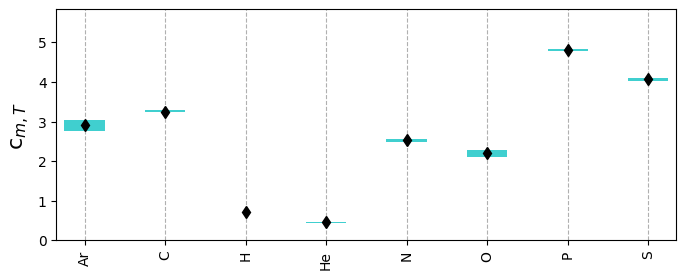

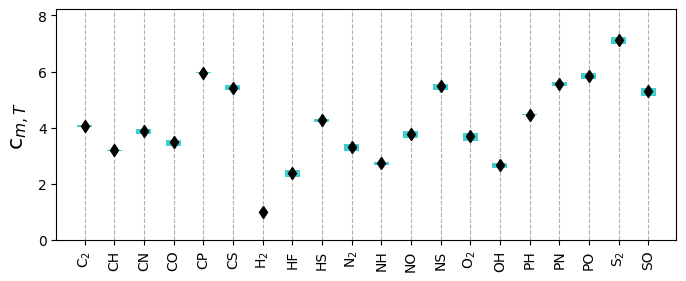

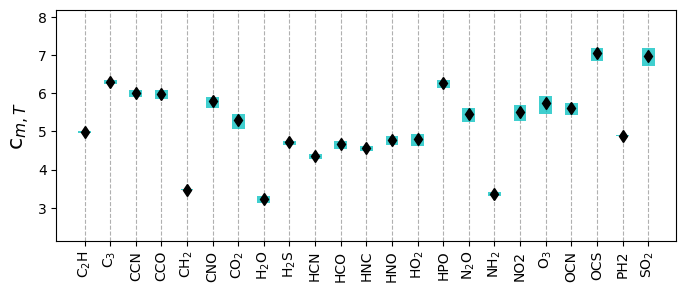

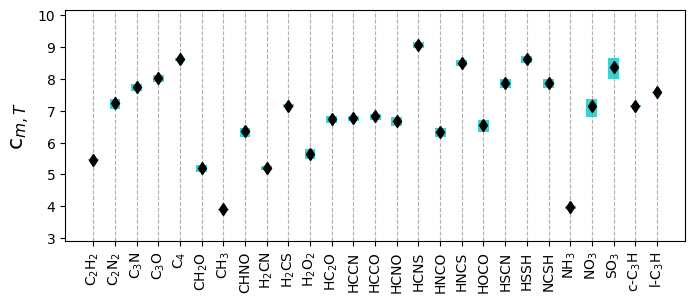

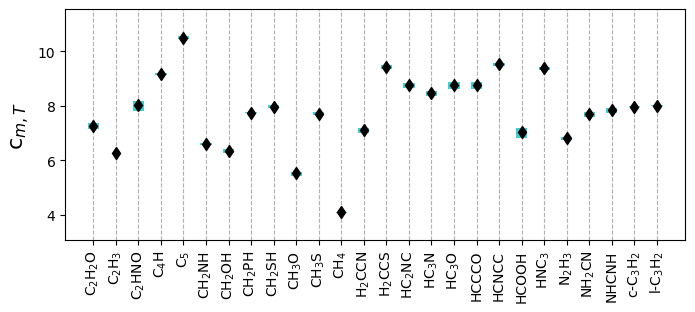

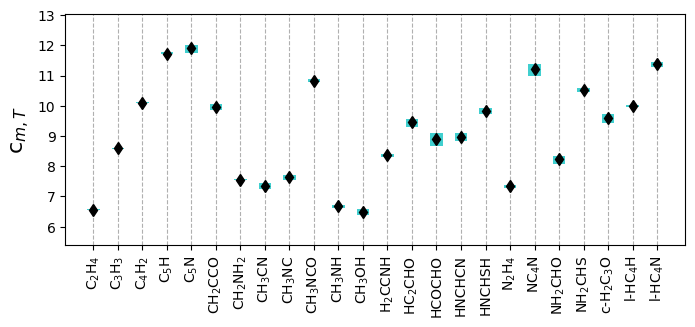

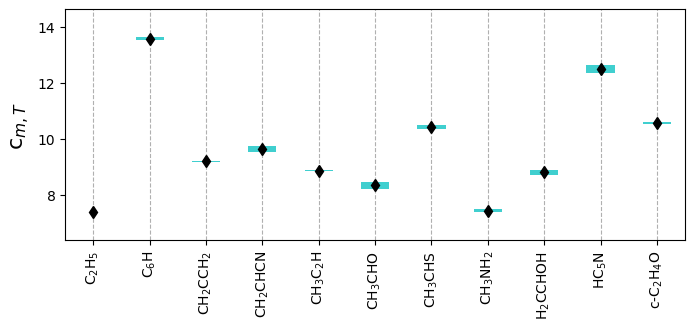

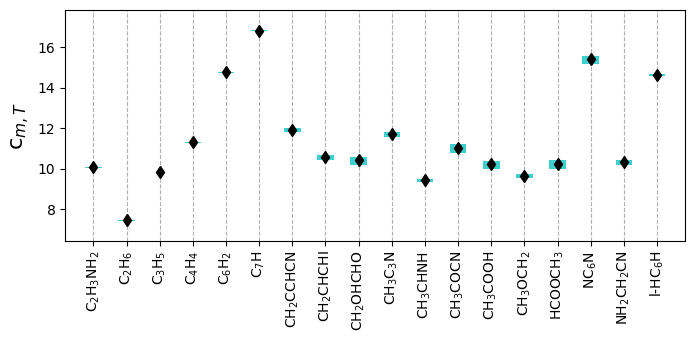

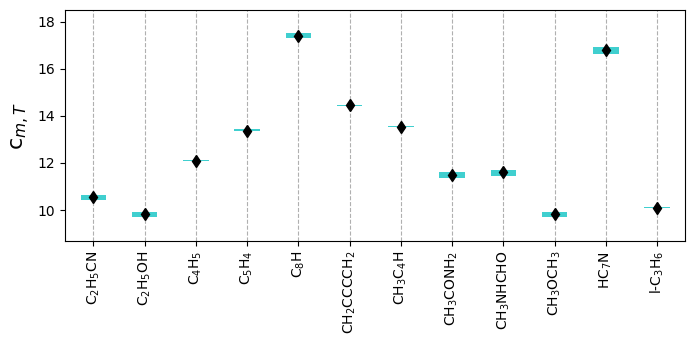

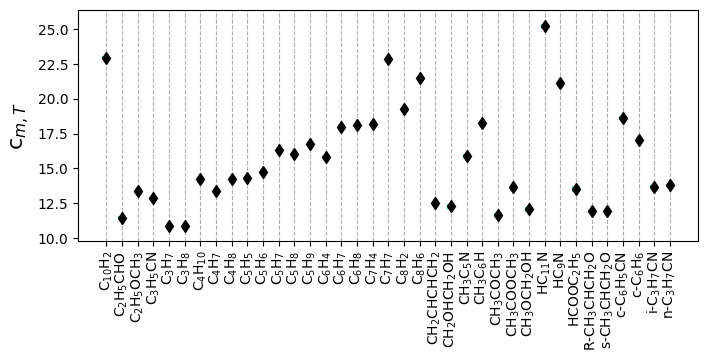

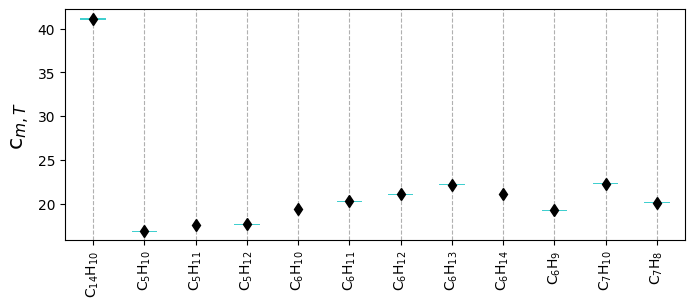

In [48]:
if ratePlot:
    boxWidth = 0.5
    boxOffset= boxWidth/2.0
    negFreq = []
    with plt.style.context('default'):
        for iplot in range(len(NatomsList)):
            Natoms = NatomsList[iplot]
            fig = plt.figure(figsize=(8, 3))
            ax = fig.add_subplot(111)
            Nmols = len(molCoeffsAll[Natoms])
            mols = []
            minCoeff = 999999
            maxCoeff = -999999
            bebBoxes = []
            hfBoxes = []
            Nmols = 0
            for (i, mol) in enumerate(sorted(molCoeffsAll[Natoms], key=lambda x: x['name'])):
                mols.append(molLatex[mol['name']])
                ciMax = max(mol['BEB'])
                ciMin = min(mol['BEB'])
                ciMean= mol['mBEB']
                minCoeff = min(ciMin, minCoeff)
                maxCoeff = max(ciMax, maxCoeff)
                bebBoxes.append(Rectangle((i-boxOffset, ciMin), boxWidth, (ciMax - ciMin)))
                ax.plot(i, ciMean, 'kd', zorder=999)
                Nmols += 1
            pcBeb = PatchCollection(bebBoxes, facecolor='c', alpha=0.75,
                                edgecolor=None, zorder=2)
            hfBeb = PatchCollection(hfBoxes, facecolor='r', alpha=0.75,
                                edgecolor=None, zorder=2)
            ax.add_collection(pcBeb)
            ax.add_collection(hfBeb)

            ax.set_ylim(max(0, minCoeff-1), maxCoeff+1)      
            ax.set_xticks(range(Nmols), mols, rotation=90)
            ax.set_ylabel(r'c$_{m, T}$', fontsize=16)
            ax.tick_params(which='both', axis='both', labelsize=10)
            ax.grid(axis='x', linestyle='--')
            plt.show()

Store all the mean rates in a single dictionary for the network file and make a new dictionary of the rates sorted by molecule name.

In [49]:
meanMolCoeff = {}
for Natoms in NatomsList:
    for (i, mol) in enumerate(sorted(molCoeffsAll[Natoms], key=lambda x: x['name'])):
        meanMolCoeff[mol['name']] = mol['mBEB']
sortedMolIonRates =  {key: value for key, value in sorted(meanMolCoeff.items())}

Output in the two different formats, following the UMIST and KIDA formats. See the sites for the format:
- UMIST: <http://umistdatabase.net/>
- KIDA: <https://kida.astrochem-tools.org/>


In [50]:
if networkFormat.lower() == "kida":
    header_line = ff.FortranRecordWriter('(3A11,1x,5A11,1x,e10.3,1x,e10.3,1x,e10.3,e9.2,1x,e8.2,1x,A4,1x,i2,1x,i6,1x,i6,1x,i2,1x,i5,1x,i2,1x,i1)')
    offset = 0
    molStrArr = []

    i = 0
    for moli in sortedMolIonRates.keys():
        molionStr = '%s+'%moli
        molStr = header_line.write([moli.upper(), 'CR', '', ('%s+'%moli).upper(), 'e-', '', '', '', sortedMolIonRates[moli], 0.0, 0.0, 2.0, 0.0, 'logn', 1, -9999, 9999, 1, offset+i, 1, 1])
        molStrArr.append(molStr)
        i += 1
    with open("./alecs.kida.in", 'w') as f:
        for li in molStrArr:
            f.write('%s\n'%li)


In [51]:
if networkFormat.lower() == "umist":
    molStrArr = []
    i = 0
    for moli in sortedMolIonRates.keys():
        molionStr = '%s+'%moli
        molStr = "%d,%s,CRP,,%s,e-,,,%.2e,0.00,0.0,L,10,41000,C,ALECS\n"%(i, moli, molionStr,sortedMolIonRates[moli]*1.3E-17)
        molStrArr.append(molStr)
        i += 1
    with open("./alecs.umist.d", 'w') as f:
        for li in molStrArr:
            f.write('%s'%li)
